###### Author: Kaustubh M. Harapanahalli
# Basic Neural Network to train an NLP model on IMDB Review Data set
### Importing the necessary packages and libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


Separating the text and the labels of each review into a list of labels and texts

In [2]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Initializing number of training samples, validation samples, maximum number of words to consider and the maximum number of words that are going to be considered in an individual review

In [3]:
maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000

Tokenizing the text into numerical format so as to support the training of the data based on the initialized hyperparameters

In [4]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


Normalizing the data and the labels and bring all the data to the same shape

In [5]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Data Split

In [6]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Loading the pre-trained model from glove

In [7]:
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Model Initialization

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 80008     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,080,729
Trainable params: 1,080,729
Non-trainable 

Setting the 0th layer as non-trainable as we want to consider the pre-trained weights obtained from glove

In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Model Training

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

model.save_weights('pre_trained_glove_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8000 samples, validate on 10000 samples
Epoch 1/40
8000/8000 [==============================] - 2s - loss: 0.6747 - acc: 0.5631 - val_loss: 0.6238 - val_acc: 0.6538
Epoch 2/40
8000/8000 [==============================] - 2s - loss: 0.5601 - acc: 0.7139 - val_loss: 0.6154 - val_acc: 0.6623
Epoch 3/40
8000/8000 [==============================] - 2s - loss: 0.4751 - acc: 0.7741 - val_loss: 0.6057 - val_acc: 0.6826
Epoch 4/40
8000/8000 [==============================] - 2s - loss: 0.4144 - acc: 0.8082 - val_loss: 0.8230 - val_acc: 0.6274
Epoch 5/40
8000/8000 [==============================] - 2s - loss: 0.3683 - acc: 0.8394 - val_loss: 0.6617 - val_acc: 0.6954
Epoch 6/40
8000/8000 [==============================] - 2s - loss: 0.3288 - acc: 0.8533 - val_loss: 0.9193 - val_acc: 0.6456
Epoch 7/40
8000/8000 [==============================] - 1s - loss: 0.2901 - acc: 0.

8000/8000 [==============================] - 1s - loss: 0.0747 - acc: 0.9704 - val_loss: 2.4735 - val_acc: 0.6769
Epoch 33/40
8000/8000 [==============================] - 1s - loss: 0.0665 - acc: 0.9733 - val_loss: 2.4162 - val_acc: 0.6755
Epoch 34/40
8000/8000 [==============================] - 1s - loss: 0.0656 - acc: 0.9735 - val_loss: 2.3774 - val_acc: 0.6775
Epoch 35/40
8000/8000 [==============================] - 1s - loss: 0.0662 - acc: 0.9725 - val_loss: 2.8170 - val_acc: 0.6747
Epoch 36/40
8000/8000 [==============================] - 2s - loss: 0.0968 - acc: 0.9709 - val_loss: 2.4636 - val_acc: 0.6751
Epoch 37/40
8000/8000 [==============================] - 1s - loss: 0.0712 - acc: 0.9720 - val_loss: 2.4128 - val_acc: 0.6739
Epoch 38/40
8000/8000 [==============================] - 1s - loss: 0.0676 - acc: 0.9741 - val_loss: 2.5558 - val_acc: 0.6746
Epoch 39/40
8000/8000 [==============================] - 2s - loss: 0.0657 - acc: 0.9739 - val_loss: 2.8123 - val_acc: 0.6775
Epoc

### Epochs vs Loss and Epochs vs Accuracy plot

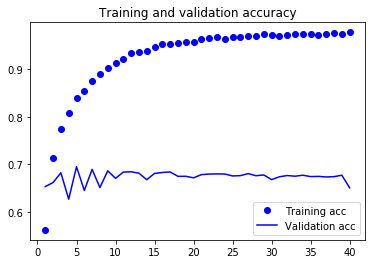

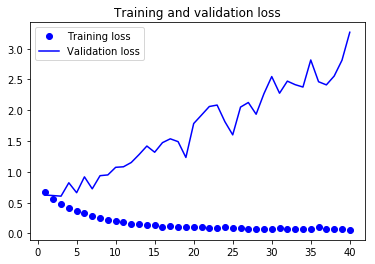

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### Initializing test Data

In [14]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

### Model evaluation

In [15]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

24544/25000 [============================>.] - ETA: 0s

[3.2739860227854085, 0.65528]

In [16]:
model.load_weights('best_model.h5')
model.evaluate(x_test, y_test)

24416/25000 [============================>.] - ETA: 0s

[0.6575623295593261, 0.69612]